# Preprocessing gene and protein data

1.  Loading data into a gene expression matrix.
2.  Munging data
3.  Quick shot at maching learning, to make sure data is ok.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

import os # Working with file directories, etc.

from IPython.display import display # Pretty display of data frames.

# Put plots inline rather than in a pop-up.
%matplotlib inline

## 1.  Loading the data

Start at section 2, if the raw data has already been processed and pickled.

In this section, we load the gene and protein expression data and some metadata.  The sequencing data is stored in a series of quant.sf files, one for each cell.  The metadata is stored in a separate file.  The protein data is stored in a separate file.  We use the metadata to select single-cells from an experiment.  The first function loads the metadata.

In [2]:
def get_meta(experiment, filename = 'META_DATA_InVitro.csv', report=True):
    df = pd.read_csv(filename, sep=',',
                     index_col=2, header=0, low_memory=False)
    df = df[ df['Project_ID'] == experiment] # Only cells from the experiment.
    df = df[ df['Number_Of_Cells'] == 1] # Get rid of bulks.
    if report:
        print('{} single cells found in experiment {}'.format(len(df), experiment))
        clones = df['Clone_ID'].unique()
        print('{} Clones: {}'.format(len(clones), ', '.join(clones)))
        print('The first five rows of the dataframe are below')
        display(df[:5])
    return df

In [3]:
meta_df = get_meta('P1902', filename = 'META_DATA_MARTY_InVitro_FEB8.csv')

361 single cells found in experiment P1902
9 Clones: E4, A7, A8, G6, G8, H2, H9, B4, F3
The first five rows of the dataframe are below


,Project_ID,Donor,Number_Of_Cells,Clone_ID,In_Vivo_Clone_ID
Sample_ID,,,,,
P1902_1289,P1902,YFV2001,1,E4,52.0
P1902_1290,P1902,YFV2001,1,E4,52.0
P1902_1291,P1902,YFV2001,1,E4,52.0
P1902_1292,P1902,YFV2001,1,E4,52.0
P1902_1293,P1902,YFV2001,1,A7,46.0


The sequencing data (in a quant.sf file) contains a separate row for each *isoform* of each gene.  The name of each row contains various information (separated by pipe-characters), from which we extract the gene name.

In [4]:
def get_genename(longname):
    split_name = longname.split('|') # Separate by pipe
    if len(split_name) >= 5: # Avoid spike-ins.
        return split_name[5] # Gene name happens to be in 5th slot.
    else:
        return 'notagene'

The following function locates a quant.sf file from a cell name.  This is dependent on the directory structure.  Once located, the data is loaded into a data frame and output.

In [5]:
def load_cell(sample_id):
    path = sample_id[:5]
    folderlist = os.listdir(path)
    folders = [f for f in folderlist if sample_id in f]
    if len(folders) == 0:
        raise FileNotFoundError('Cell data not found')
        return None
    elif len(folders) > 1:
        print('Multiple files found, and I cannot choose.')
        return None
    else:
        cwd = os.getcwd()
        path_to_cell = os.path.join(path,folders[0],'quant.sf')
        df = pd.read_csv(path_to_cell, sep='\t',
                         index_col=0, header=0, low_memory=False)
        df.index = [get_genename(longname) for longname in df.index]
        df = df.loc[ df.index != 'notagene']
        df.name = sample_id
        return df

The data for each cell is complicated -- more than we need to work with.  We care about the counts for each gene, putting all isoforms together at the moment.  The following function takes a dataframe for a cell, and outputs a series of gene expressions, indexed by genes.  We use the TPM-normalized gene expressions here.  As these are transcripts-per-million, their sum should be somewhat close to 1 million.  Perhaps there is some deficiency from 1 million due to skipping ERCC spike-ins?

In [6]:
def get_TPM(cell, tolerance = 10000, verbose = False):
    cg = cell.groupby(cell.index)['TPM'].sum()
    cg.name = cell.name
    sum_error = np.abs(cg.sum() - 1000000)
    if verbose:
        print('Gene expression (TPM) found for {} genes.'.format(len(cg)))
        print('{0:2.0%} of expressions are zero.'.format(cg.astype(bool).sum() / len(cg)))
    if sum_error <= tolerance:
        return cg
    else:
        if verbose:
            print('Warning:  TPM total should be within {} of 1 million.'.format(tolerance))
        return cg

The next function loads an entire *list* of cells, and places their gene expression data into the rows of a matrix.  The rows are indexed by the cell names, and the columns by genes.  The data is the TPM-normalized gene expression.  This may take a little while, so we give progress updates every 10 cells.

In [7]:
def expression_matrix(cell_list):
    list_of_df = []
    cells_processed = 0
    for cell_name in cell_list:
        cell = load_cell(cell_name)
        list_of_df.append(get_TPM(cell, verbose=False))
        cells_processed += 1
        if cells_processed % 10 == 0:
            cells_remaining = len(cell_list) - cells_processed
            print('{} cells processed and {} cells remaining.'.format(cells_processed, cells_remaining))
    return pd.concat(list_of_df, axis=1).transpose()

In [8]:
EM_raw = expression_matrix(list(meta_df.index))

10 cells processed and 351 cells remaining.
20 cells processed and 341 cells remaining.
30 cells processed and 331 cells remaining.
40 cells processed and 321 cells remaining.
50 cells processed and 311 cells remaining.
60 cells processed and 301 cells remaining.
70 cells processed and 291 cells remaining.
80 cells processed and 281 cells remaining.
90 cells processed and 271 cells remaining.
100 cells processed and 261 cells remaining.
110 cells processed and 251 cells remaining.
120 cells processed and 241 cells remaining.
130 cells processed and 231 cells remaining.
140 cells processed and 221 cells remaining.
150 cells processed and 211 cells remaining.
160 cells processed and 201 cells remaining.
170 cells processed and 191 cells remaining.
180 cells processed and 181 cells remaining.
190 cells processed and 171 cells remaining.
200 cells processed and 161 cells remaining.
210 cells processed and 151 cells remaining.
220 cells processed and 141 cells remaining.
230 cells processed

Now we load the protein data.  We give a list of "default" proteins to look for here.

In [9]:
proteins_default = ['CD57', 'FAS', 'PTPRC-CD45RA', 'CD4', 'IL7RA','Dextramer', 
                    'CD3E', 'CD8A', 'CCR7', 'ITGA6-CD49F', 'PDCD1', 'CD27']

In [10]:
def get_proteins(filename, cell_list, proteins = proteins_default):
    df = pd.read_csv(filename, sep=',',
                      index_col=0, header=0, low_memory=False)
    df = df.loc[cell_list]
    proteins_occurring = [p for p in proteins if p in df.columns]
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

In [11]:
protein_df = get_proteins('P1902_protein.csv', list(EM_raw.index))

In [12]:
EM_raw.to_pickle('P1902_EM_raw.pkl') # Save file as a pickle.
meta_df.to_pickle('P1902_meta.pkl') # Pickle the metadata too.
protein_df.to_pickle('P1902_protein.pkl') # Pickled proteins.  Mmmmm...

## 2.  Munging data

Now we filter and log-scale the gene expression data, for downstream use.

In [13]:
EM_raw = pd.read_pickle('P1902_EM_raw.pkl') # Load expression matrix from a pickle.
meta_df = pd.read_pickle('P1902_meta.pkl') # Load metadata from a pickle.
protein_df = pd.read_pickle('P1902_protein.pkl') # Load proteins from a pickle

In [14]:
genes = list(EM_raw.columns)  # The names of the genes. 
cells = list(EM_raw.index) # The names of the cells.
proteins = list(protein_df.columns) # The names of the proteins
clones = sorted(list(meta_df.Clone_ID.unique())) # The names of the clones

### Removing TCRs and rarely-expressed genes

T cells have special genetically rearranged receptors called TCRs.  These are made of segments called TRBV9, TRBJ2-4, TRAV12-2, TRAJ14, etc.  Bascally any gene that is called these letters followed by a number -- TRBV, TRBJ, TRAV, TRAJ -- is part of this receptor and they are defined as being clonal.  Therefore we exclude these genes since we want to find more interesting similarities within clonal populations.

The following loads a list of genes to be excluded from the data for later analysis.  The excluded genes should be given in a csv file with *one* column.  No row labels should be given.  The first row should be a descriptive header, like "Genes to exclude."

In [15]:
exc_filename = 'TRgenes.csv'  # CHANGE this if needed.  I added TRAC and TRDV3 as requested.
exc_df = pd.read_csv(exc_filename, sep=',', header=0)
exclude_genes = exc_df.iloc[:,0].tolist()

In [16]:
'TRAC' in exclude_genes # Just checking.

True

In [17]:
def get_relevant(gf, eg, prevalence=0.05, threshold = 10):
    '''
    Outputs True if the gene is relevant for analysis.  We throw out excluded genes.
    By default, we take genes that are found in at least 5% of all cells at a level of
    10 counts or more.
    '''
    nonzero_count = (gf > threshold).sum(axis=0)
    nonzero_proportion = nonzero_count / len(gf)
    return [gene for gene in gf.columns if
           (gene not in eg) and 
           (nonzero_proportion[gene] > prevalence)]

In [18]:
genes_relevant = get_relevant(EM_raw, exclude_genes)

In [19]:
print("{} cells are measured, from {} to {}.".format(len(cells), cells[0], cells[-1])) 
print("{} genes are measured, from {} to {}.".format(len(genes),genes[0],genes[-1]))
genes_excluded = [gene for gene in exclude_genes if gene in genes]
print("{} TCR genes were excluded, from {} to {}.".format(len(genes_excluded), genes_excluded[0], genes_excluded[-1]))
print("{} genes are considered relevant, from {} to {}.".format(len(genes_relevant), genes_relevant[0], genes_relevant[-1]))

361 cells are measured, from P1902_1289 to P1902_1672.
20209 genes are measured, from A1BG to ZZZ3.
194 TCR genes were excluded, from TRGC1 to TRDV3.
7418 genes are considered relevant, from A1BG to ZZZ3.


### Removing poor quality libraries and overexpressing cells

Next we remove poor quality libraries -- by removing cells which express too few genes.  We also remove cells that may be dividing, and thus express too many genes.  To visualize this, we produce "violin-plots" giving the number of genes expressed by each cell, sorted by clonality.

In [20]:
def nGene(ge, md, cutoff = 10, plot=True):
    nG = ge.apply(lambda row: sum(row > cutoff), axis=1) # Number of genes expressed.
    nG.name = 'num_genes'
    clonalities = md.Clone_ID
    nGene_df = pd.concat([nG, clonalities], axis=1)
    if plot:
        fig,ax = plt.subplots(figsize=(12,8))
        sns.violinplot(x="Clone_ID", y="num_genes", inner='quartiles', data=nGene_df, ax=ax)
        sns.swarmplot(x="Clone_ID", y="num_genes", color="white", size=3, data=nGene_df, ax=ax);
    return nGene_df

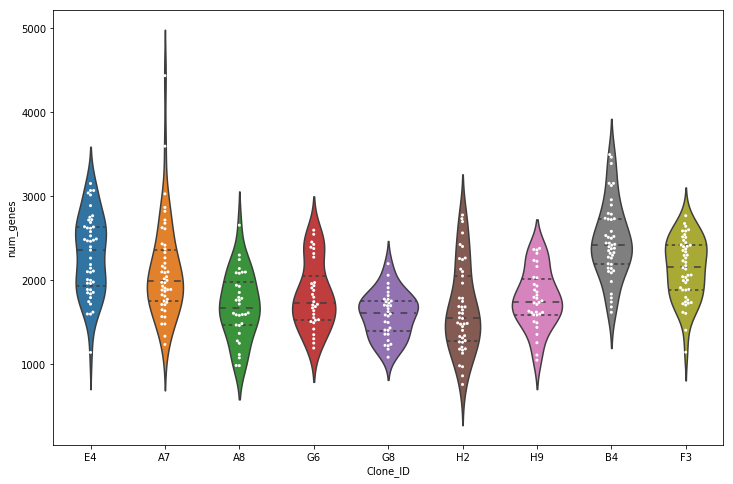

In [21]:
nG = nGene(EM_raw, meta_df)

Now we pick out the "good cells", whose expressed-gene-number is within two standard deviations of the mean (within each clone).

In [22]:
nG_std = nG.groupby('Clone_ID').apply(np.std)
nG_means = nG.groupby('Clone_ID').apply(np.mean)
nG_lowcut = (nG_means - 2*nG_std).num_genes
nG_highcut = (nG_means + 2*nG_std).num_genes
cells_good = [c for c in cells if 
              (nG.num_genes[c] >= nG_lowcut[nG.Clone_ID[c]]) and 
              (nG.num_genes[c] <= nG_highcut[nG.Clone_ID[c]]) 
             ]
print('{} cells remaining after {} poor libraries removed.'.format(len(cells_good), len(cells) - len(cells_good)))

347 cells remaining after 14 poor libraries removed.


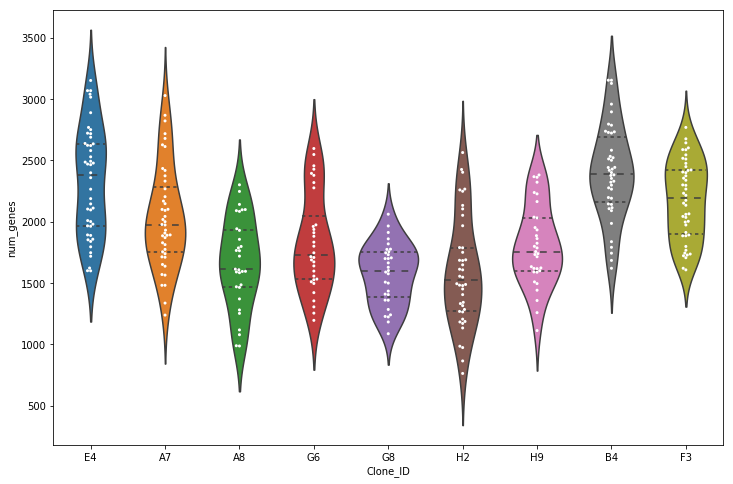

In [23]:
nG = nGene(EM_raw.loc[cells_good], meta_df.loc[cells_good]) # Post-trimming violin-plot.

### Clipping and log-normalization

Now we normalize our gene expression matrix.  We only use the good cells (throwing out bad libraries).  We cut off all negative gene-expression, and normalize the gene expression on a log-scale.  In the end, a gene-expression value of $x$ will be replaced by $\log(1 + max(x,0))$ (natural logarithm).

In [24]:
EM = EM_raw[genes_relevant].copy()  # Only use relevant genes.
EM = EM.loc[cells_good] # Only use good cells.
EM.clip_lower(0, inplace = True) # Clip any negative values to zero.
EM = EM.transform(np.log1p) # Apply log(1+x) transform.

Now we examine the zeros (dropouts) and means in this matrix.  For each gene, we look at two quantities:  the *nonzero ratio* is the proportion of cells which express the gene (above the cutoff).  The *mean nonzero* is the mean of the (log-normalized) expression of the gene, restricting to the expressions above the cutoff.

The following function creates a dataframe with the nonzero ratio and mean nonzero value for every gene, using a given cutoff.  By default, the cutoff should be given in "absolute" terms, i.e., before log-normalization.  A cutoff of 10 seems reasonable.

In [25]:
def dropmean(df, cutoff, absolute=True):
    behave_df = df.copy()
    no_cells = len(behave_df)
    max_expression = behave_df.max()
    if absolute:
        co = np.log1p(cutoff)
    else:
        co = cutoff
    behave_df = behave_df.clip(co,max(max_expression))
    dropout_df = behave_df.apply(lambda column: ((column > co).sum()) / no_cells )
    meannz_df = behave_df.apply(lambda column: column.replace(co, np.nan).mean())
    dm_df = pd.concat([dropout_df, meannz_df], axis=1)
    dm_df = dm_df.rename(columns={0: "Nonzero Ratio", 1: "Mean nonzero"})
    return dm_df

To choose a reasonable cutoff, one can begin with a cutoff of zero, then increase the cutoff until the graph below loses the blob at the bottom right.  In other words, we should not find a clump of genes with very high nonzero ratio and low mean nonzero value.

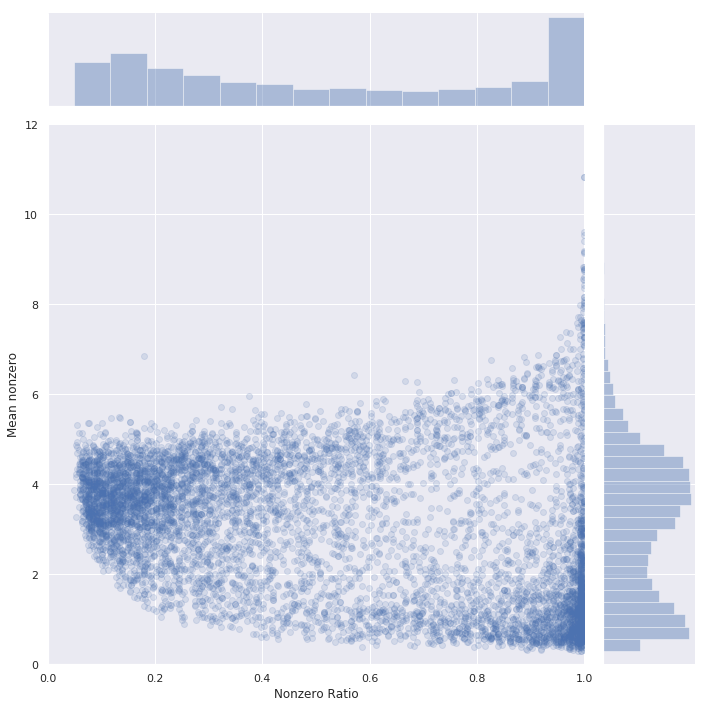

In [27]:
dm_df = dropmean(EM, 0) # Begin with cutoff at zero.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=10)

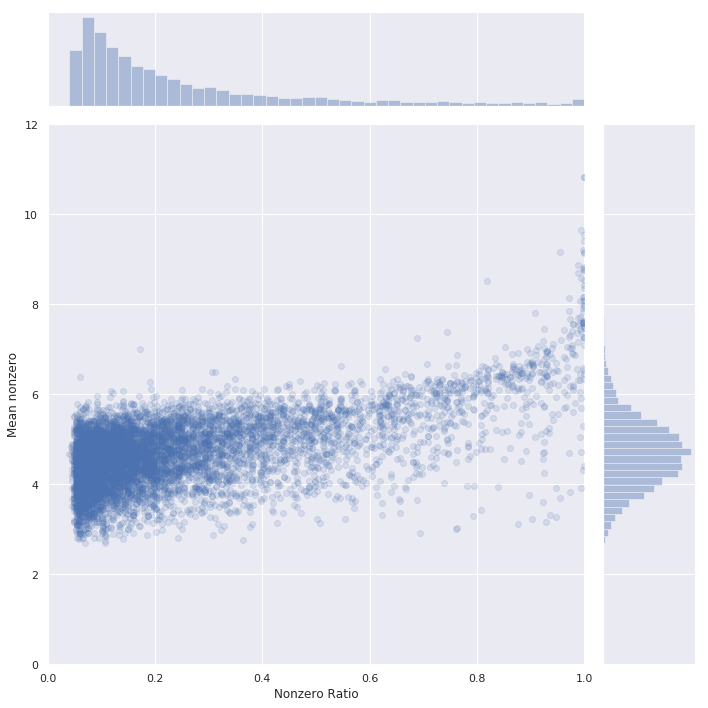

In [28]:
dm_df = dropmean(EM, 10) # Now impose a cutoff of 10.
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'],
               alpha=.15, xlim=(0,1), ylim=(0,12), height=10)

The 10-count cutoff effectively removed the heavy blob of genes on the bottom-right.  But still, the genes around the bottom right are a bit suspicious, and could be due to bad libraries.  The following labels genes as "suspect" if they lie in a rectangle with high nonzero-ratio and low mean-nonzero value.

In [29]:
def is_suspect(df, nzr_min = 0.95, mn_max = 5.5):
    '''
    Identifies genes as suspect if their nonzero ratio is above nzr_min
    and their mean nonzero expression (log1p-scaled) is below mn_max.
    The default mn_max 5.5 corresponds to a TPM count of 244.
    '''
    x = df['Nonzero Ratio']
    y = df['Mean nonzero']
    return ((x > nzr_min) & (y < mn_max))

In [30]:
suspect_mask = is_suspect(dm_df, 0.95, 5.5)
genes_suspect = list(suspect_mask[suspect_mask].index)
print('The following genes are suspected bad librarys: \n {}.'.format(', '.join(genes_suspect)))

The following genes are suspected bad librarys: 
 CLDN11, CTNNB1, GMFB, GPM6A, HNRNPL, MTRNR2L1, MTRNR2L6, SON, TNFSF13B.


We highlight the suspect genes in red.

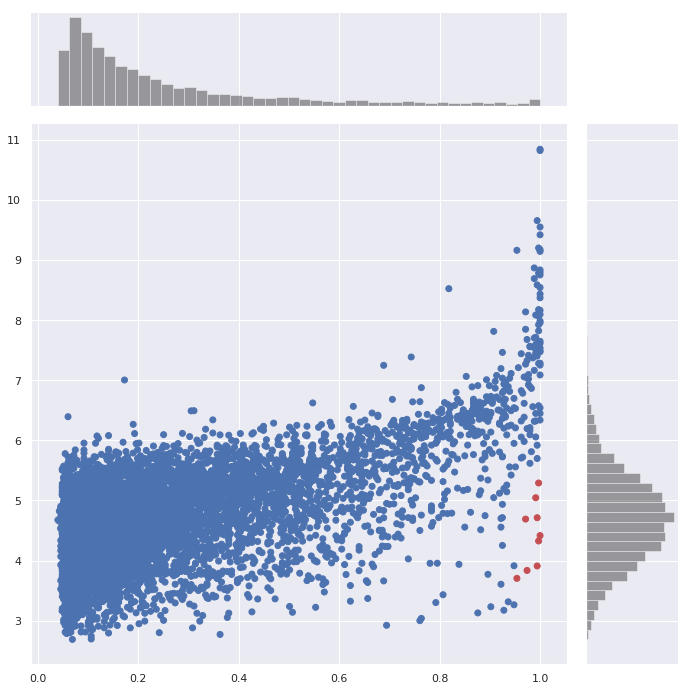

In [31]:
dm_df['color'] = 'b'
for gene in dm_df.index:
    if suspect_mask[gene]:
        dm_df.loc[gene,'color'] = 'r'
        
sns.set(style="darkgrid")
fig = sns.jointplot(x=dm_df['Nonzero Ratio'], y=dm_df['Mean nonzero'], color='k',
               alpha=.15, xlim=(0,1), ylim=(0,12), height=10)

fig.ax_joint.cla()
plt.sca(fig.ax_joint)
plt.scatter(dm_df['Nonzero Ratio'], dm_df['Mean nonzero'], c=dm_df['color'])
plt.show()

In [32]:
EM = EM.drop(genes_suspect, axis=1) # Drop the suspect genes.
EM.to_pickle('P1902_EM.pkl') # Save file as a pickle.  This will be used for downstream analysis.
print('Expression matrix pickled, with shape {}'.format(EM.shape)) 

Expression matrix pickled, with shape (347, 7409)


## 3.  Quick shot at machine learning

After preprocessing the data, one might want to quickly check how well gene expression can predict clonotype.  The following steps will test out a linear support vector classifier. 

In [33]:
import statsmodels.api as sm

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew # For detecting bimodality
from statsmodels.formula.api import ols

from bisect import bisect # See bisect.bisect.
from itertools import compress # I don't recall why this is here.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn.preprocessing import Binarizer, MinMaxScaler

from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV

from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC # Linear Support Vector Classifier 
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE


In [34]:
X = EM
X_cells = X.index
y = meta_df.loc[X_cells].Clone_ID

In [35]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000))

In [36]:
# DANGER DANGER:  The following suppresses all warnings from Python.
# Otherwise, you'll probably get a bunch of convergence warnings...
# Alternatively, increase the number of iterations in the SVM.

import warnings
warnings.filterwarnings('ignore') # Ignore warnings.

param_grid = dict(linearsvc__C=[0.001, 0.01, 0.1, 1.0, 10, 100],
                  selectkbest__k = range(50,251,25),
                 )

grid_search = GridSearchCV(SVMpipe, param_grid=param_grid, cv=5, iid=False) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selectkbest', SelectKBest(k=100, score_func=<function f_classif at 0x1a2e892c80>)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'linearsvc__C': [0.001, 0.01, 0.1, 1.0, 10, 100], 'selectkbest__k': range(50, 251, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

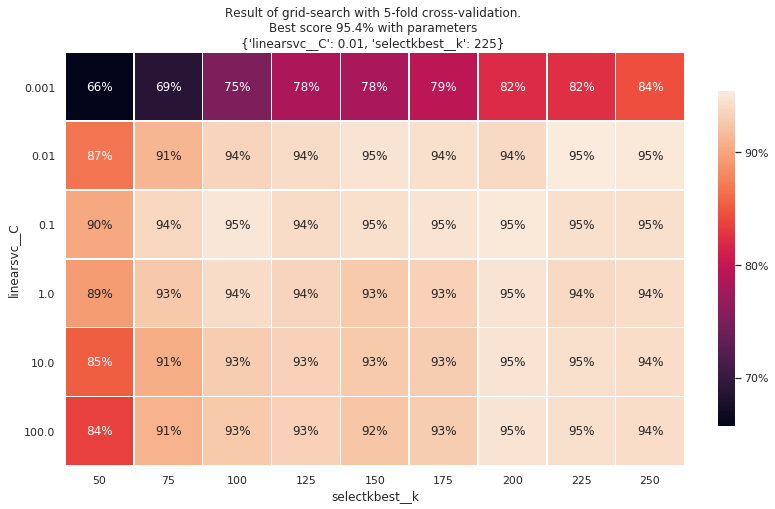

In [38]:
CV_map(grid_search)

In [39]:
from sklearn import base

def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(len(classes)+1,len(classes)))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

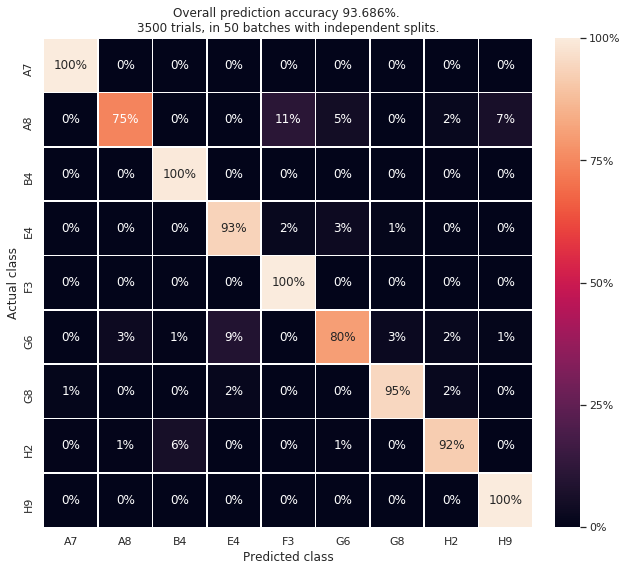

In [40]:
opt_k = grid_search.best_params_['selectkbest__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['linearsvc__C'] # Use optimal C-parameter for linear SVM.

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))

confusion_matrix(X,y,SVMpipe, reps=50, classlist = clones)